# Accuracy Assessment

### Psuedocode
- Generate classifier output for entire scene containing qc labels
- Determine exact offset necessary to align with qc labels
- Create output chunk that aligns with qc labels
- generate diff raster of output with qc labels
- generate diff raster of output with burton-johnson labels
- generate histograms
- load band stack
- identify characteristics of pixels that are incorrectly classified
- identify characteristics of images with higher error

In [150]:
import os
import rasterio as rio
import rasterio.windows as wnd
import rasterio.transform as transform
from src.utils.data_directory_manager import DataDirectoryManager
import matplotlib.pyplot as plt
import numpy as np

In [151]:
base_dir = os.path.join(os.getcwd(), "data")
dm = DataDirectoryManager(base_dir)
qc_dir = os.path.join(dm.project_dir, "qc")

Get list of downloaded scene ids that contain the qc chunks.

In [152]:
qc_scenes = [i[:-8] for i in os.listdir(qc_dir)]
raw_scenes = [i for i in os.listdir(dm.raw_image_dir)]
available_qc = [i for i in raw_scenes if i in qc_scenes]

In [153]:
test_scene_id = available_qc[0]
test_scene_b2_path = os.path.join(dm.raw_image_dir, test_scene_id, test_scene_id + "_B2.TIF")
test_scene_qc_path = os.path.join(qc_dir, test_scene_id + "_man.tif")
assert os.path.exists(test_scene_b2_path)
assert os.path.exists(test_scene_qc_path)
print(test_scene_id)

LC80631112014002LGN00


generate window of qc chunk

In [154]:
with rio.open(test_scene_qc_path) as qc_chunk:
    qc_bounds = qc_chunk.bounds
    qc_meta = qc_chunk.meta.copy()
    qc_transform = qc_chunk.transform
    
    qc_window = wnd.Window(0, 0, qc_meta['width'], qc_meta['height'])

In [157]:
with rio.open(test_scene_b2_path) as image:
    image_meta = image.meta.copy()
    image_transform = image.transform
    window = wnd.from_bounds(qc_bounds[0],
                                    qc_bounds[1],
                                    qc_bounds[2],
                                    qc_bounds[3],
                                    transform=image_transform)
    
    rounded_window = wnd.Window(round(window.col_off), round(window.row_off), window.width, window.height)
    b2_qc_extent = image.read(1, window=rounded_window)

Window(col_off=3343.9913472672306, row_off=3237.187371551743, width=333.0, height=333.0)


In [182]:
test_stacked_dir = os.path.join(dm.project_dir, "stacked_chunks", test_scene_id)
assert os.path.exists(test_stacked_dir)

In [201]:
def mosaic_label(scene_chunk_dir_path, scene_meta):
    columns = (scene_meta['width'] // 512)
    rows = (scene_meta['height'] // 512)
    label_columns = []
    for i in range(rows):
        label_row = []
        for j in range(columns):
            chunk_path = os.path.join(scene_chunk_dir_path, "chunk_{}_{}_label.npy".format(i, j))
            if os.path.exists(chunk_path):
                label_row.append(np.load(chunk_path))
            else:
                label_row.append(np.zeros((512, 512), dtype=int))
        label_columns.append(np.concatenate(tuple(label_row), axis=1))
    mosaic = np.concatenate(tuple(label_columns), axis=0)
    return mosaic
                                 

In [210]:
mosaic = mosaic_label(test_stacked_dir, image_meta)


In [218]:
mosaic_qc_chunk = mosaic[rounded_window.row_off:rounded_window.row_off + 333,
                         rounded_window.col_off:rounded_window.col_off + 333]
print(mosaic_qc_chunk.shape)

(333, 333)


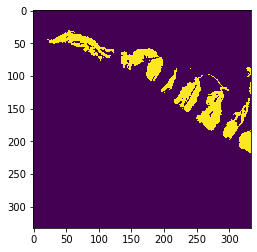

In [230]:
plt.imshow(mosaic_qc_chunk)

In [204]:
with rio.open(os.path.join(dm.label_dir, test_scene_id + "_label.TIF")) as label_f:
    label_raster = label_f.read(1)

In [206]:
print(mosaic.shape)

(7680, 7680)


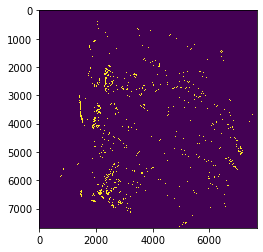

In [209]:
plt.imshow(label_raster[:7680,:7680])

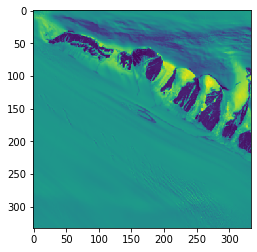

In [158]:
plt.imshow(b2_qc_extent)

Mosaic chunks into full scene

In [168]:
chunk_left = rounded_window.row_off / 512
chunk_right = (rounded_window.row_off + rounded_window.height) / 512
chunk_top = rounded_window.col_off / 512
chunk_bottom = (rounded_window.col_off + rounded_window.width) / 512

print(chunk_left, chunk_right)
print(chunk_top, chunk_bottom)

6.322265625 6.97265625
6.53125 7.181640625


In [169]:
left_index = (chunk_left - int(chunk_left)) * 512
right_index = (chunk_right - int(chunk_right)) * 512
print(left_index, right_index)

165.0 498.0


In [173]:
top_index = (chunk_top - int(chunk_top)) * 512
bottom_index = (chunk_bottom - int(chunk_bottom)) * 512
print(top_index, bottom_index)

272.0 93.0


In [115]:
chunks = sorted(os.listdir(test_stacked_dir))
row = 5
col = 5
chunk_origin_path = os.path.join(test_stacked_dir, "chunk_{}_{}.npy".format(row, col))
chunk_right_path = os.path.join(test_stacked_dir, "chunk_{}_{}.npy".format(row, col + 1))
chunk_down_path = os.path.join(test_stacked_dir, "chunk_{}_{}.npy".format(row + 1, col))
chunk_diag_path = os.path.join(test_stacked_dir, "chunk_{}_{}.npy".format(row + 1, col + 1))

In [116]:
chunk_origin = np.load(chunk_origin_path)
chunk_right = np.load(chunk_right_path)
chunk_down = np.load(chunk_down_path)
chunk_diag = np.load(chunk_diag_path)

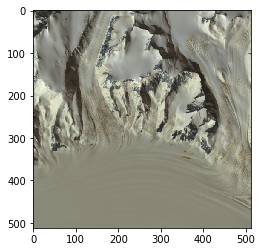

In [123]:
im_max = np.max(chunk_origin[:,:,2:5])
rgb = chunk_origin[:,:,2:5] / im_max
plt.imshow(rgb)

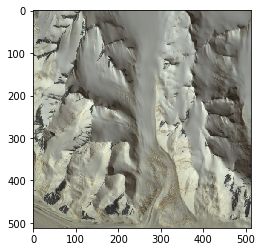

In [125]:
im_max2 = np.max(chunk_right[:,:,2:5])
rgb2 = chunk_right[:,:,2:5] / im_max2
plt.imshow(rgb2)

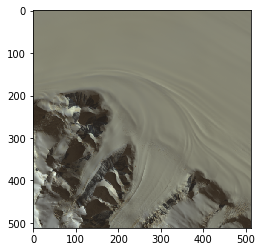

In [126]:
im_max3 = np.max(chunk_down[:,:,2:5])
rgb3 = chunk_down[:,:,2:5] / im_max3
plt.imshow(rgb3)

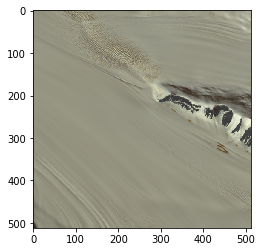

In [127]:
im_max4 = np.max(chunk_diag[:,:,2:5])
rgb4 = chunk_diag[:,:,2:5] / im_max4
plt.imshow(rgb4)

In [175]:
top_row = np.concatenate((rgb,rgb2), axis=1)
bottom_row = np.concatenate((rgb3, rgb4), axis=1)
full = np.concatenate((top_row, bottom_row), axis=0)

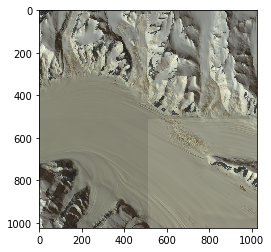

In [176]:
plt.imshow(full)